In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as st
import statsmodels.api as sm
import forecast
from scipy import stats
from pandas import DataFrame
from sklearn.cross_validation import train_test_split
from statsmodels.sandbox.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from dateutil.parser import parse
import scipy.stats as scs
import forecast
#Stop warnings
import warnings
warnings.filterwarnings("ignore")
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

/Users/ChristopherHyland/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/ChristopherHyland/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Only running the models on store 1 for now.

In [2]:
ts=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True)
ts2=pd.read_csv('Rossman Sales.csv')
ts2 = ts2[ts2['Store'] ==1]

### EDA

In [3]:
def generateMonSales(storenum, allstores):
    """Returns monthly sales for any particular store we specify"""
    data=pd.read_csv('Rossman Sales.csv')
    if allstores == False:
        data = data[data['Store'] ==storenum]
    #Parse string dates into datetime object:
    newdate = []
    for x in data['Date']:
        newdate.append(parse(x))
    data['Date'] = newdate
    #Sort the data by month:
    month = []
    for x in data['Date']:
        month.append(x.month)
    data['Month'] = month
    monthlysales = data.groupby(data['Month'])
    return monthlysales.sum()['Sales']

In [4]:
%matplotlib inline

def plotGraph(data, storenum, allstores):
    """Generates plot of univariate sales over a year"""
    fig, ax = plt.subplots()
    data.plot(color='red')
    ax.set_xlabel('Month')
    
    if allstores == False:
        ax.set_ylabel('Sales')
        ax.set_title('Sales over months for store %s' %storenum)
    else:
        ax.set_ylabel('Sales $100 million')
        ax.set_title('Sales over months for all stores')
    sns.despine()
    plt.show()

In [5]:
def processdata(storenumber):
    """Get a single store, and transform holiday column."""
    finaldata=pd.read_csv('Rossman Sales.csv')
    finaldata = finaldata[finaldata['Store'] ==storenumber]
#    noweekendfinaldata = finaldata[finaldata['DayOfWeek'] != 6]
#    noweekendfinaldata2 = noweekendfinaldata[noweekendfinaldata['DayOfWeek'] != 7]
    dummies = pd.get_dummies(finaldata[['StateHoliday']],  drop_first=True)
    finaldata=finaldata.join(dummies)
    finaldata.rename(columns={'StateHoliday_0':'NoHoliday',
                                        'StateHoliday_a': 'PublicHoliday', 
                                        'StateHoliday_b': 'EasterHoliday', 
                                        'StateHoliday_c':'ChristmasHoliday'}, inplace=True)
    del finaldata['NoHoliday']
    del finaldata['StateHoliday']
    del finaldata['Store']
    return finaldata

In [6]:
def processdata2(storenumber, allStores):
    """Get a single store, remove weekends, and holidays."""
    finaldata=pd.read_csv('Rossman Sales.csv')
    if allStores == False:
        finaldata = finaldata[finaldata['Store'] ==storenumber]
    noweekendfinaldata = finaldata[finaldata['DayOfWeek'] != 6]
    noweekendfinaldata2 = noweekendfinaldata[noweekendfinaldata['DayOfWeek'] != 7]
    dummies = pd.get_dummies(noweekendfinaldata2[['StateHoliday']],  drop_first=True)
    noweekendfinaldata2=noweekendfinaldata2.join(dummies)
    noweekendfinaldata2.rename(columns={'StateHoliday_0':'NoHoliday',
                                        'StateHoliday_a': 'PublicHoliday', 
                                        'StateHoliday_b': 'EasterHoliday', 
                                        'StateHoliday_c':'ChristmasHoliday'}, inplace=True)

    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['PublicHoliday'] != 1]
    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['EasterHoliday'] != 1]
    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['ChristmasHoliday'] != 1]
    del noweekendfinaldata2['NoHoliday']
    del noweekendfinaldata2['StateHoliday']
    del noweekendfinaldata2['Store']
    del noweekendfinaldata2['PublicHoliday']
    del noweekendfinaldata2['EasterHoliday']
    del noweekendfinaldata2['ChristmasHoliday']
    return noweekendfinaldata2

In [7]:
finaldata = processdata(1)

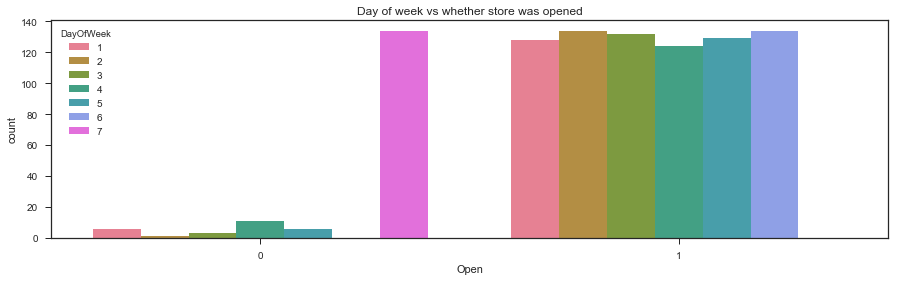

In [8]:
#Plot to see what days stores are closed
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open', hue='DayOfWeek',data=finaldata,palette="husl", ax=axis1)
plt.title('Day of week vs whether store was opened')

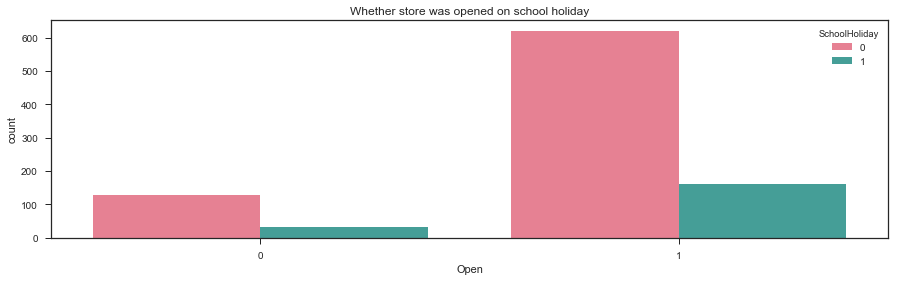

In [9]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open', hue='SchoolHoliday',data=finaldata,palette="husl", ax=axis1)
plt.title('Whether store was opened on school holiday')
#No school holiday is pink and school holiday is green

Stores tend to be opened most of the time even if there was a school holiday. The right 2 columns denotes the count of the stores are opened and then broken down into whether was it a school holiday or not when it was opened.

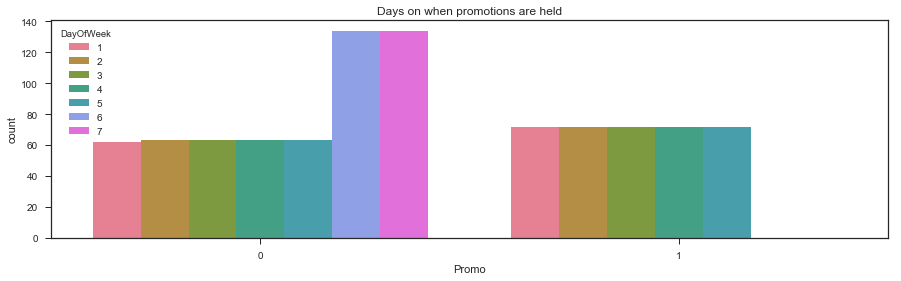

In [10]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Promo', hue='DayOfWeek',data=finaldata,palette="husl", ax=axis1)
plt.title('Days on when promotions are held')
#Promotion are spread over the days

Promotions uniformly spread throughout the week. No promotions at all on the weekends since stores are closed.

In [11]:
def convertDates():
    """Converts date variable into year and month."""
    data=pd.read_csv('Rossman Sales.csv')
    data = data[data['Store'] ==1]
    data['Year'] = data['Date'].apply(lambda x: int(str(x)[:4]))
    data['Month'] = data['Date'].apply(lambda x: int(str(x)[5:7]))
    return data

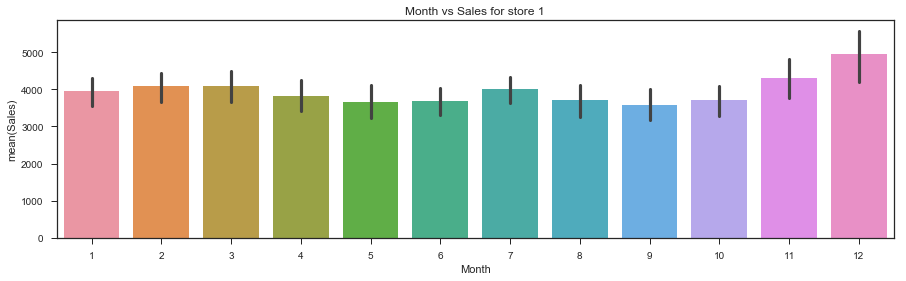

In [12]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Month',y='Sales', data=convertDates(), ax=axis1)
plt.title('Month vs Sales for store 1')

Store 1 tends to sell more goods during November and December

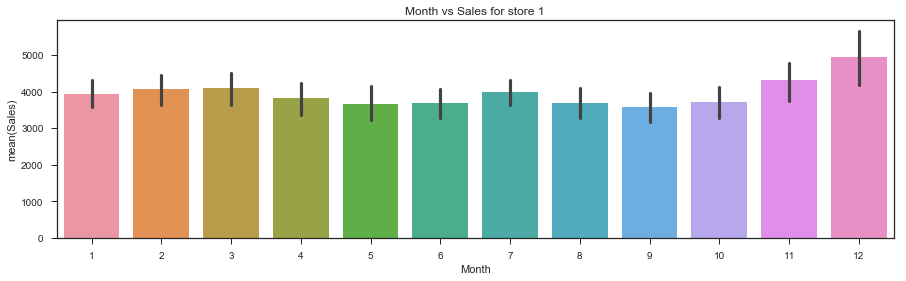

In [13]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Month',y='Sales', data=convertDates(), ax=axis1)
plt.title('Month vs Sales for store 1')

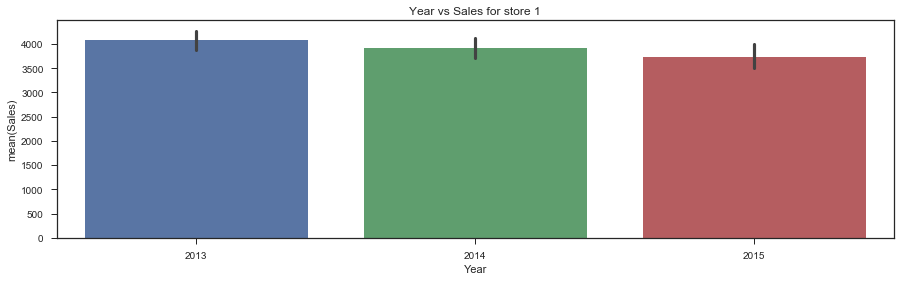

In [14]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Year',y='Sales', data=convertDates(), ax=axis1)
plt.title('Year vs Sales for store 1')

Sales has fallen throughout the years.

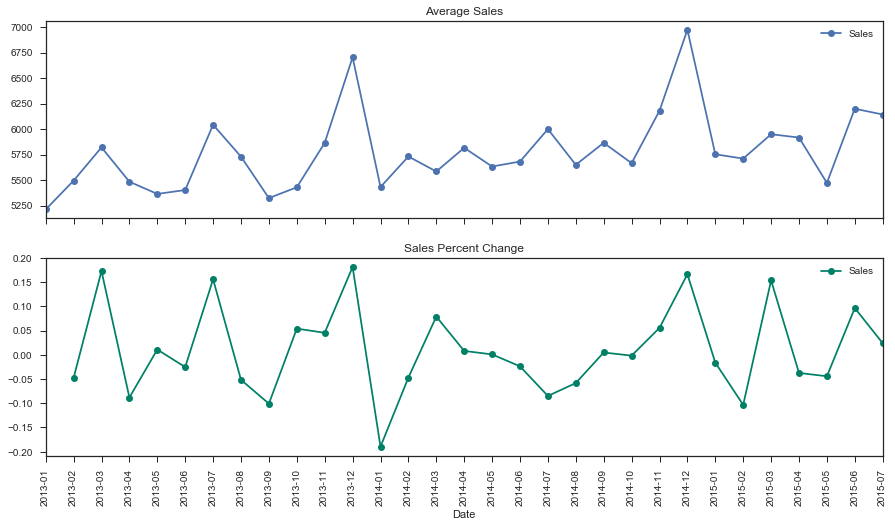

In [15]:
rossman = pd.read_csv('Rossman Sales.csv')
rossman['Year']  = rossman['Date'].apply(lambda x: int(str(x)[:4]))
rossman['Month'] = rossman['Date'].apply(lambda x: int(str(x)[5:7]))
rossman['Date'] = rossman['Date'].apply(lambda x: (str(x)[:7]))

average_sales    = rossman.groupby('Date')["Sales"].mean()
pct_change_sales = rossman.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")

Monthly sales analysis.

Talk about trends and tell me if you notice anything

# Models

I've removed weekends in order to make the forecasting easier.

Stores are closed only on Sundays. Therefore, we remove from dataset but then add them back in after predictions.

In [119]:
"""Get a single store, remove weekends, and holidays."""
finaldata=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
finaldata = finaldata[finaldata['Store'] ==1]
noweekendfinaldata = finaldata[finaldata['DayOfWeek'] != 6]
noweekendfinaldata2 = noweekendfinaldata[noweekendfinaldata['DayOfWeek'] != 7]
dummies = pd.get_dummies(noweekendfinaldata2[['StateHoliday']],  drop_first=True)
noweekendfinaldata2=noweekendfinaldata2.join(dummies)
noweekendfinaldata2.rename(columns={'StateHoliday_0':'NoHoliday',
                                    'StateHoliday_a': 'PublicHoliday', 
                                    'StateHoliday_b': 'EasterHoliday', 
                                    'StateHoliday_c':'ChristmasHoliday'}, inplace=True)

noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['PublicHoliday'] != 1]
noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['EasterHoliday'] != 1]
noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['ChristmasHoliday'] != 1]
del noweekendfinaldata2['NoHoliday']
del noweekendfinaldata2['StateHoliday']
del noweekendfinaldata2['Store']
del noweekendfinaldata2['PublicHoliday']
del noweekendfinaldata2['EasterHoliday']
del noweekendfinaldata2['ChristmasHoliday']

store_one_data = noweekendfinaldata2

In [120]:
store_one_data.index=store_one_data.index.to_period(freq='D')
y = store_one_data['Sales']
y = y.iloc[::-1]

#Data is processed!

In [121]:
y.describe().round(2)

count     647.00
mean     4721.01
std      1037.92
min      2362.00
25%      3924.00
50%      4607.00
75%      5360.00
max      9528.00
Name: Sales, dtype: float64

Not that much skewness when comparing mean to median. Mean sales for store 1 is $4721.

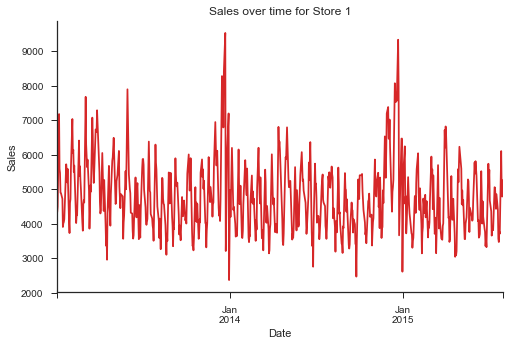

In [19]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales over time for Store 1')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

Seasonality seems present. Data appears to be stationary.

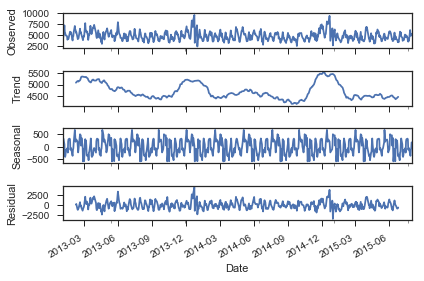

In [21]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
y.interpolate(inplace = True)
y2 = y.copy(deep = True)
y2.index=y.index.to_timestamp()
res = sm.tsa.seasonal_decompose(y2, freq=52)
fig = plt.figure()  
fig = res.plot() 

High degree of seasonality here.

Broken it down by components. There is seasonality and there appears to be a trend. Module 11 slide 16-17 to discuss more stuff. The seasonal variation does not seem proportional to the trend, therefore we use the $\textbf{additive model}$

Monthly analysis of store 1 whereby we now sum up sales for each month for store 1.

In [24]:
monthly_data = y.resample('M').sum()

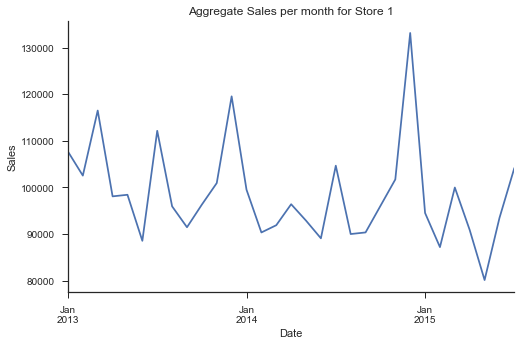

In [25]:
fig, ax= plt.subplots(figsize=(8,5))
monthly_data.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Aggregate Sales per month for Store 1')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

In [26]:
monthly_data.index = monthly_data.index.to_timestamp()

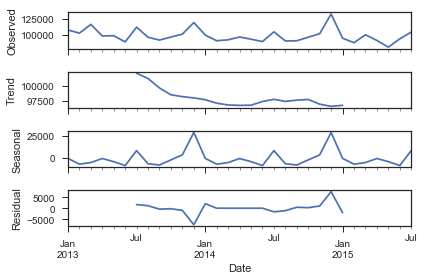

In [27]:
res = sm.tsa.seasonal_decompose(monthly_data, model='additive', freq=12)
fig = plt.figure()  
fig = res.plot() 

Seasonality is even more pronounced now during the December period.

Data decomposition for this.

http://www.johnwittenauer.net/a-simple-time-series-analysis-of-the-sp-500-index/

http://www.statsmodels.org/stable/release/version0.6.html?highlight=seasonal#seasonal-decomposition

## Simple Exponential Forecasting and Random Walk

In [28]:
#Removed weekends and holidays
ses=forecast.ses(y)
ses.fit()
fitted2=pd.Series(ses.smooth(), index=y.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.703 (0.047) 

 In-sample fit:
 MSE               823453.620
 Log-likelihood   -5324.532
 AIC               10655.063
 BIC               10668.480


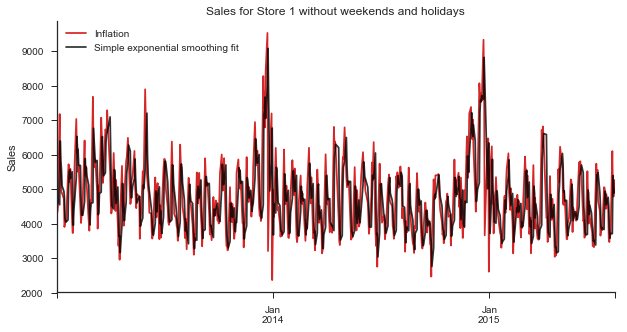

In [29]:
fig, ax= plt.subplots(figsize=(10,5))
y.plot(color=red, label='Inflation')
fitted2.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.set_title('Sales for Store 1 without weekends and holidays')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

We evaluate the results and see whether error terms are Gaussian.

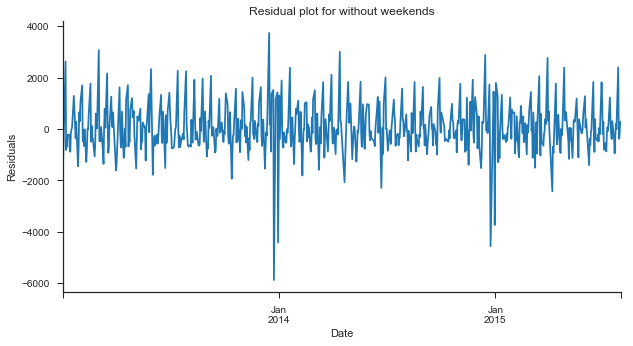

In [30]:
resid2=y-fitted2
fig, ax= plt.subplots(figsize=(10,5))
resid2.plot(color=blue)
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot for without weekends')
sns.despine()
plt.show()

Noticeable changes in variance during January.

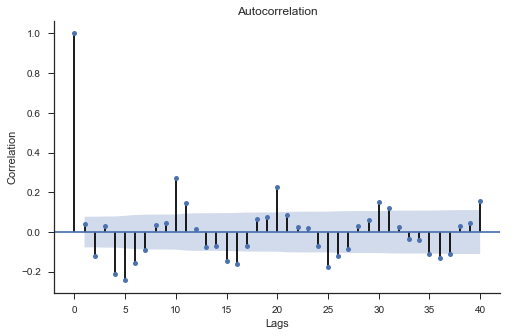

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')
ax.set_title('Correlogram for residuals')
sm.graphics.tsa.plot_acf(resid2, lags=40, ax=ax)
sns.despine()
plt.show()

From the correlogram above, there appears to be seasonal fluctuations in the dataset. There appears to be non-randonmess in the residuals, which is an issue. However, there isn't too much correlation in actual terms. The blue bars are intervals telling us how significant the correlation is. 

https://stats.stackexchange.com/questions/182627/interpretation-of-correlogram

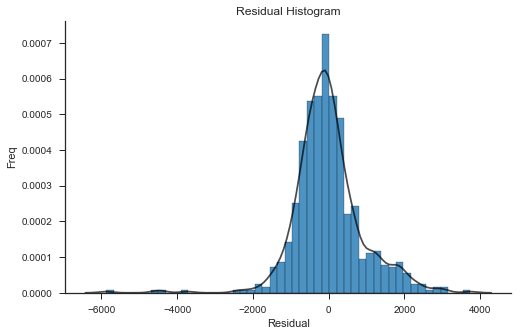

In [32]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    ax.set_xlabel('Residual')
    ax.set_ylabel('Freq')
    ax.set_title('Residual Histogram')
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid2)
plt.show()

Skewed residuals. Big issue.

Model validation

In [33]:
from statlearning import rmse_jack

# Same thing but for no weekend/holiday
validation2=y['2015-06-01':].index # 
start = y.index.get_loc('2015-06-01') # 

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['Rand Walk', 'Simple Exp', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation2)

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Rand Walk,751.066,116.540
Simple Exp,984.572,105.985


Random walks performs better than simple exponential. Now we forecast data (be way of the fact that residuals are not normally distributed).

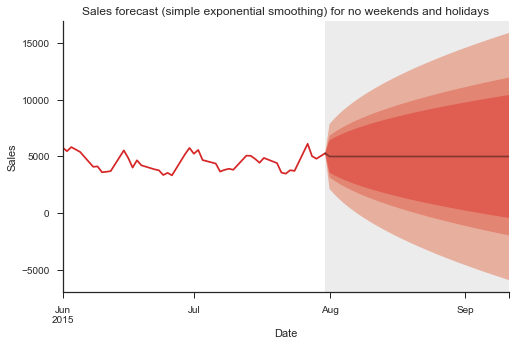

In [34]:
h=42

model = ses

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

pred=pd.Series(model.forecast(h), index=test)

intv1=pd.DataFrame(model.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(model.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(model.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['2015-06-01':], pred, intv1, intv2, intv3)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_xticks([], minor=True)
plt.title('Sales forecast (simple exponential smoothing) for no weekends and holidays')

sns.despine()
plt.show()

### Moving Average

In [35]:
# Real time forecasting - use it as a template. Forecasting 2 months of data

validation=y['2015-06-01':].index # 
start = y.index.get_loc('2015-06-01') # 

pred1 = []
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    summ = 0
    for j in range(1,8):
        summ += y.iloc[i-j]
    summ = summ/7
    
    pred1.append(summ) # 7 day average
    
    model = forecast.ses(y.iloc[:i]) 
    model.fit()

columns=['Moving Average', 'Actual']
results = np.vstack([pred1,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Moving Average,936.439,72.625


Thisnext  method is just when we took the average of past 7 days to help predict the next sales.

### Weighted Moving Average (different to the lecture's version)

In [36]:
# Real time forecasting - use it as a template. Forecasting 2 months of data
# 4 day weighted average.

validation=y['2015-06-01':].index # 
start = y.index.get_loc('2015-06-01') # 

pred1 = []
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    weights = [0.4,0.3,0.2,0.1]
    summ = 0
    for j in range(1,5):
        summ += (y.iloc[i-j]*weights[j-1])
    
    pred1.append(summ) # 4 day weighted average
    
    model = forecast.ses(y.iloc[:i]) 
    model.fit()

columns=['Weighted Average', 'Actual']
results = np.vstack([pred1,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Weighted Average,831.569,109.939


### Holt Exponential Smoothing

In [37]:
holt = forecast.holt(y)
holt.fit()
holt.summary()

 Holt (trend corrected) exponential smoothing

 Smoothing parameters: 
 alpha (level) 0.703 (0.048)
 beta (trend)  0.000 (0.039)
 
 In-sample fit:
 MSE               823453.620
 Log-likelihood   -5324.532
 AIC               10655.063
 BIC               10668.480


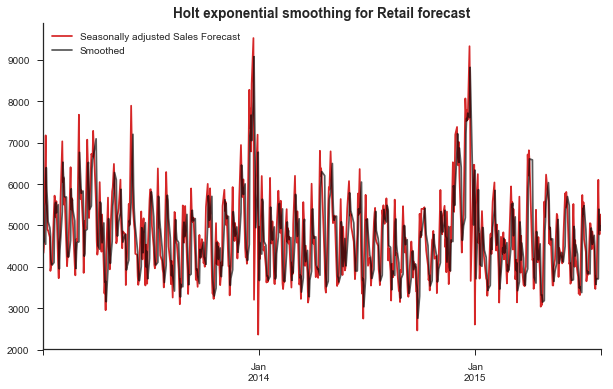

In [38]:
smoothed=pd.Series(holt.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Seasonally adjusted Sales Forecast')
smoothed.plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing for Retail forecast', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

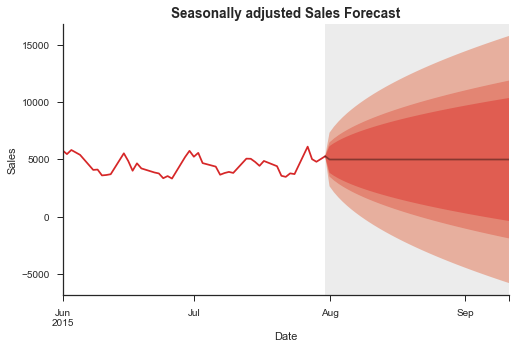

In [39]:
h=42
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

pred=pd.Series(holt.forecast(h), index=test)

intv1=pd.DataFrame(holt.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(holt.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(holt.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['2015-06-01':], pred, intv1, intv2, intv3)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_xticks([], minor=True)
plt.title('Seasonally adjusted Sales Forecast', fontsize=13.5, fontweight='bold')

sns.despine()
plt.show()

### Holt Winters Exponential Smoothing

In [40]:
ahw=forecast.holtwinters(y, additive=True, damped=False, m=12)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.625 (0.045)
 beta  (trend)    0.000 (0.040)
 delta (seasonal) 0.460 (0.078)
 
 In-sample fit:
 MSE               933789.674
 Log-likelihood   -5365.210
 AIC               10738.420
 BIC               10756.309


In [41]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.626 (0.041)
 beta  (trend)    0.000 (0.040)
 delta (seasonal) 0.456 (0.067)
 
 In-sample fit:
 MSE               945601.280
 Log-likelihood   -5369.276
 AIC               10746.552
 BIC               10764.442


In [42]:
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.626 (0.046)
 beta  (trend)    0.000 (0.130)
 delta (seasonal) 0.456 (0.091)
 phi (damping)    0.751 (0.034)
 
 In-sample fit:
 MSE               945601.287
 Log-likelihood   -5369.276
 AIC               10748.552
 BIC               10770.914


Appears additive Holt-Winters Exponential Smoothing is the base case without a damped trend (which makes sense since no trend in data for DAILY data). We did this by choosing the model with the lowest AIC.

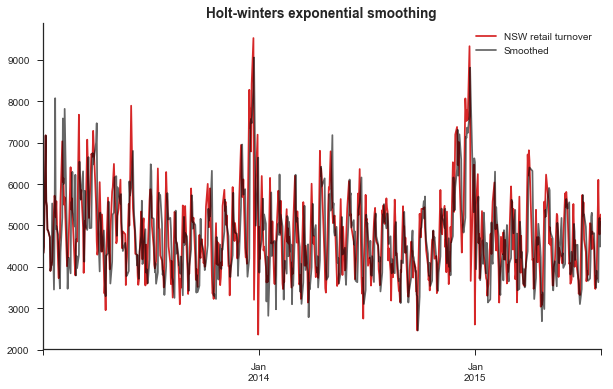

In [43]:
smoothed=pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='NSW retail turnover')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

In [44]:
# Real time forecasting 
validation=y['2015-06-01':].index # 
start = y.index.get_loc('2015-06-01') # 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(3):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,1080.70,96.35
Additive,980.32,100.94
Multiplicative,973.28,97.19


Multiplicative does best. Check residuals. 

In [45]:
model2 = forecast.holtwinters(y, additive=False, damped=False, m=42)
model2.fit()
model2.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.626 (0.041)
 beta  (trend)    0.000 (0.040)
 delta (seasonal) 0.456 (0.067)
 
 In-sample fit:
 MSE               945601.280
 Log-likelihood   -5369.276
 AIC               10746.552
 BIC               10764.442


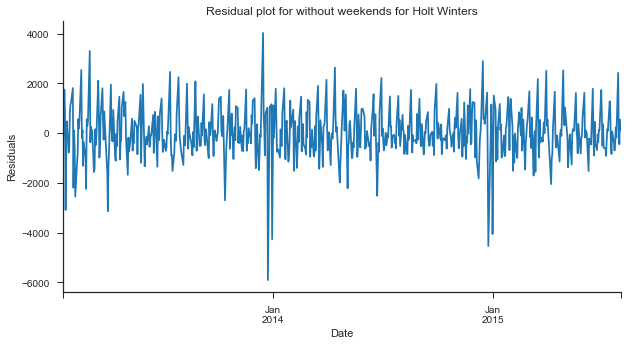

In [47]:
resid2=(y-model2.smooth())[12:]
fig, ax= plt.subplots(figsize=(10,5))
resid2.plot(color=blue)
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot for without weekends for Holt Winters')
sns.despine()
plt.show()

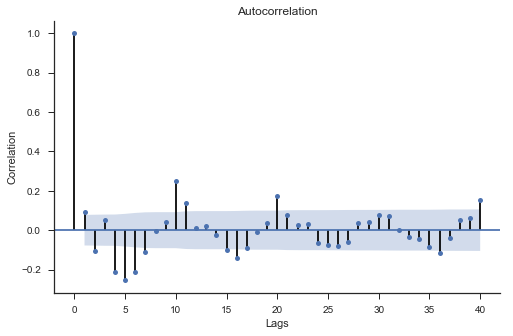

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')
ax.set_title('Correlogram for residuals')
sm.graphics.tsa.plot_acf(resid2, lags=40, ax=ax)
sns.despine()
plt.show()

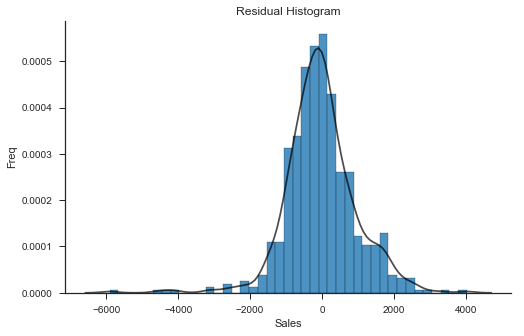

In [49]:
hist(resid2)
plt.show()

More normally distributed and therefore it is better compared to before!

In [50]:
print('Skewness of residual is ',resid2.skew())
print('Kurtosis of residual is ',resid2.kurt())

Skewness of residual is  -0.314916400532
Kurtosis of residual is  3.98107160335


We now check for linearity by plotting 1 lag of sales vs sales to see whether AR(1) model is suitable first off all.

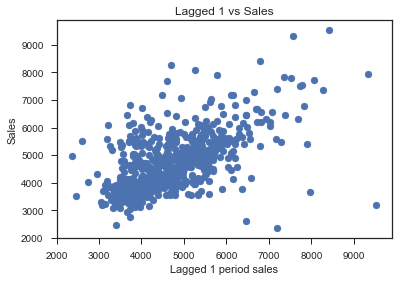

In [51]:
#Creating a lagged variable of 1 period using sales data with no weekends included in dataset
lagtr = y[:(len(y)-1)]
plt.subplot(111) 
plt.scatter(lagtr,y[1:])
plt.xlabel('Lagged 1 period sales')
plt.ylabel('Sales')
plt.title('Lagged 1 vs Sales')

Appears to be a strong linear relationship from this, so it appears that AR(1) model is suitable.

In [52]:
def test_stationarity(timeseries):
    """Test whether time series is stationary or not using Dickey-Fuller Test."""
    #Determing rolling statistics:
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

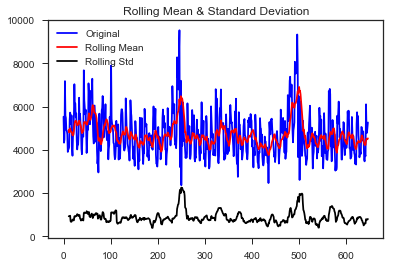

Results of Dickey-Fuller Test:
Test Statistic                  -3.856722
p-value                          0.002377
#Lags Used                      20.000000
Number of Observations Used    626.000000
Critical Value (1%)             -3.440839
Critical Value (5%)             -2.866168
Critical Value (10%)            -2.569235
dtype: float64


In [53]:
test_stationarity(y.values)

Unit Root test. Since P-value is less than 0.05, this means that we reject the $H_0$ which was that the data is not stationary. Therefore, the data is stationary.

For the graph, rolling mean and standard deviation means at any time t, we take the average of the past 12 months before it. From that, we can see whether has the mean/variance been constant over time, an important requirement for stationarity. You can read more at: https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Since data is stationary, we can run ARMA models

# AR, MA, ARIMA Model

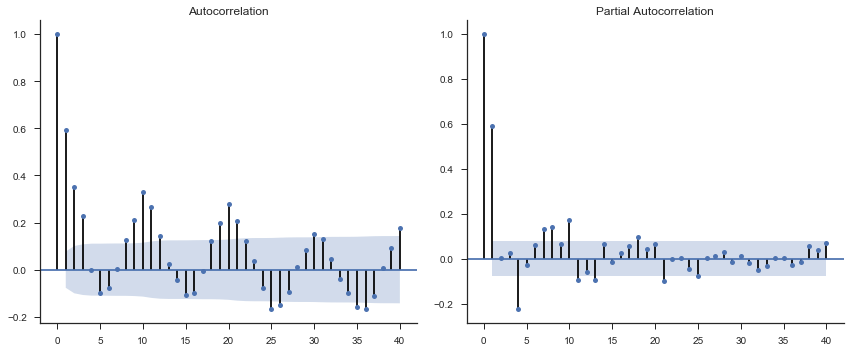

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

Contradicts results from unit root as we see decreasing ACF. This is due to sensitivity of unit root test to assumptions. Take first difference to see if it improves things. There is also noticeable seasonality in the data.

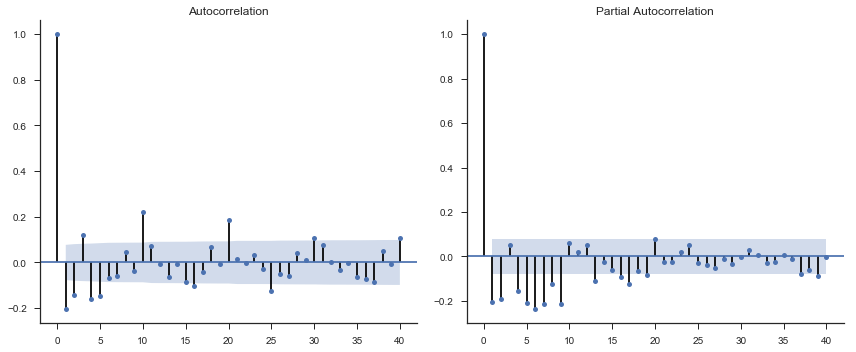

In [54]:
diff = y-y.shift(1)
diff = diff.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

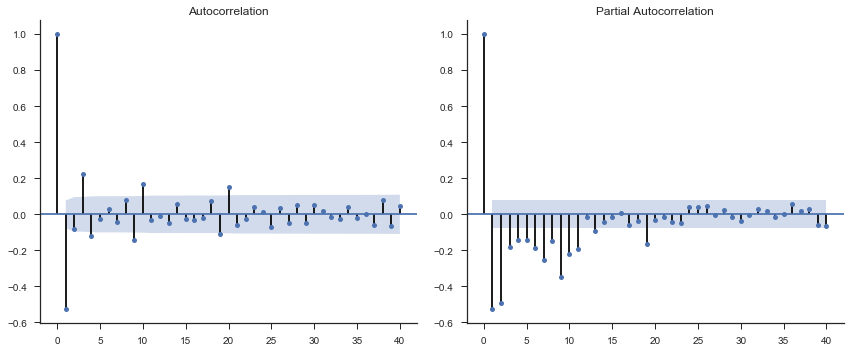

In [55]:
diff2 = diff-diff.shift(1)
diff2 = diff2.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff2, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff2, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

1st and 2nd difference was taken. From the first graph, looks like taking first difference solves the issue and turns the data into stationary data. (slide 18/63 from module 13). 

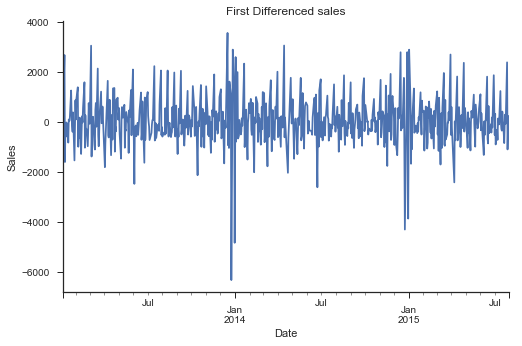

In [56]:
fig, ax = plt.subplots(figsize=(8,5))
diff.plot()
ax.set_ylabel('Sales')
ax.set_title('First Differenced sales')
sns.despine()
plt.show()

Taking first differences improved and reduced autocorrelation somewhat. And when plotting out first differenced data, we still have huge volatility in January periods.

In [57]:
#ARIMA requires numpy array to be type float, so we cast it as float
yValues = y.values.astype(float)

AR(1) Model on normal data first since looking at the ACF plot, there is massive correclation with 1 lag. We don't consider seasonality for now.

In [58]:
#No differencing
arima1 = sm.tsa.ARIMA(y,order=(1,0,0)).fit(trend='nc')
print(arima1.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  647
Model:                     ARMA(1, 0)   Log Likelihood               -5343.780
Method:                       css-mle   S.D. of innovations            932.458
Date:                Wed, 01 Nov 2017   AIC                          10691.560
Time:                        15:17:28   BIC                          10700.505
Sample:                    01-02-2013   HQIC                         10695.030
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Sales     0.9816      0.007    134.539      0.000       0.967       0.996
                                    Roots                                    
                 Real           Imaginary         

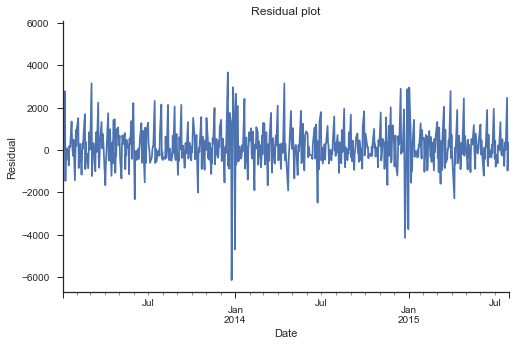

In [59]:
resid = arima1.resid

fig, ax = plt.subplots(figsize=(8,5))
resid.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.set_title('Residual plot')
sns.despine()
plt.show()

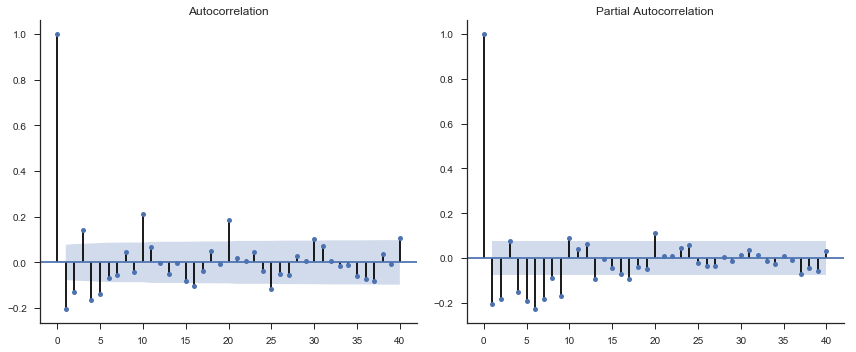

In [60]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

In [61]:
#Repeat for first differenced
arima2 = sm.tsa.ARIMA(diff,order=(1,0,0)).fit(trend='nc')
print(arima2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  646
Model:                     ARMA(1, 0)   Log Likelihood               -5323.037
Method:                       css-mle   S.D. of innovations            916.924
Date:                Wed, 01 Nov 2017   AIC                          10650.074
Time:                        15:18:21   BIC                          10659.016
Sample:                    01-03-2013   HQIC                         10653.544
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Sales    -0.2044      0.039     -5.304      0.000      -0.280      -0.129
                                    Roots                                    
                 Real           Imaginary         

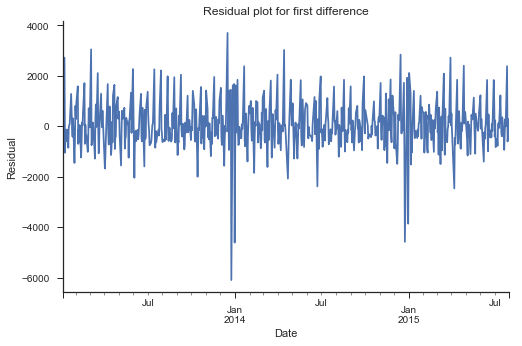

In [62]:
resid2 = arima2.resid

fig, ax = plt.subplots(figsize=(8,5))
resid2.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.set_title('Residual plot for first difference')
sns.despine()
plt.show()

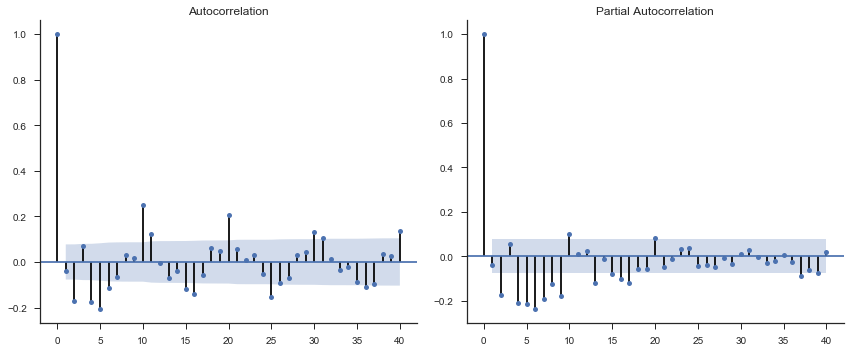

In [63]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid2, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid2, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

Results look better for first differenced AR(1) model (AIC is lower). Slide 33 of module 13. Autocorrelation falls quickly but we have an issue that partial autocorrelation is not 0 after first lag (slide 34).

We know try things using MA(1) Model

In [64]:
arima2 = sm.tsa.ARIMA(y,order=(0,0,1)).fit(trend='nc')
print(arima2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  647
Model:                     ARMA(0, 1)   Log Likelihood               -6047.767
Method:                       css-mle   S.D. of innovations           2772.292
Date:                Wed, 01 Nov 2017   AIC                          12099.535
Time:                        15:20:22   BIC                          12108.480
Sample:                    01-02-2013   HQIC                         12103.005
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1.Sales     0.8583      0.013     65.496      0.000       0.833       0.884
                                    Roots                                    
                 Real           Imaginary         

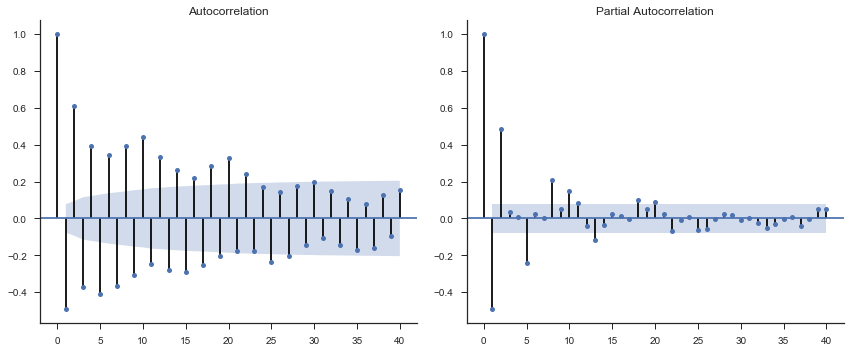

In [65]:
resid2 = arima2.resid
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid2, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid2, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

MA MODEL DOES REALLY BADLY.

In [66]:
#MA(1) with first difference
arima2 = sm.tsa.ARIMA(y,order=(0,1,1)).fit(trend='nc')
print(arima2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  646
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -5316.793
Method:                       css-mle   S.D. of innovations            908.069
Date:                Wed, 01 Nov 2017   AIC                          10637.587
Time:                        15:20:53   BIC                          10646.529
Sample:                    01-03-2013   HQIC                         10641.056
                         - 07-31-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ma.L1.D.Sales    -0.2965      0.046     -6.383      0.000      -0.387      -0.205
                                    Roots                                    
                 Real           Imaginary   

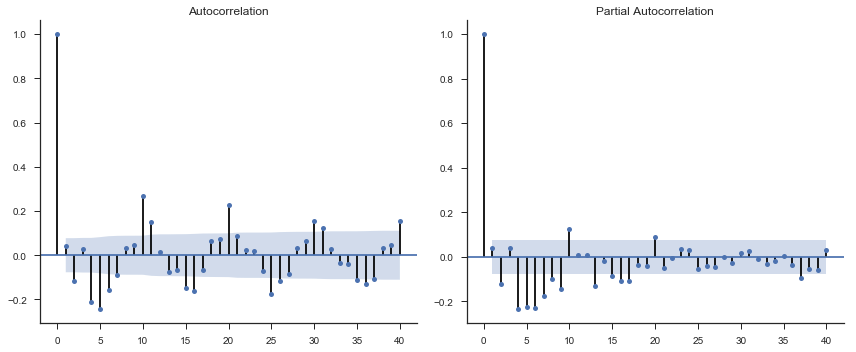

In [67]:
resid2 = arima2.resid
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid2, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid2, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

Much better now after taking first difference! Partial autocorrelation is satisfied but not autocorrelation (slide 43 of module 13)

ARMA(1) Model

In [68]:
arima3 = sm.tsa.ARIMA(diff,order=(1,0,1)).fit(trend='nc')
print(arima3.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  646
Model:                     ARMA(1, 1)   Log Likelihood               -5265.851
Method:                       css-mle   S.D. of innovations            837.106
Date:                Wed, 01 Nov 2017   AIC                          10537.702
Time:                        15:21:57   BIC                          10551.114
Sample:                    01-03-2013   HQIC                         10542.905
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Sales     0.5908      0.033     18.085      0.000       0.527       0.655
ma.L1.Sales    -0.9954      0.007   -146.642      0.000      -1.009      -0.982
                                    Roots       

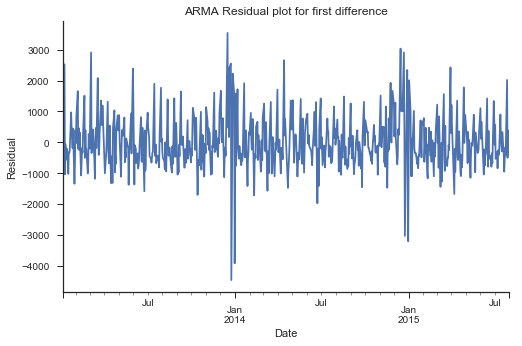

In [69]:
resid3 = arima3.resid

fig, ax = plt.subplots(figsize=(8,5))
resid3.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.set_title('ARMA Residual plot for first difference')
sns.despine()
plt.show()

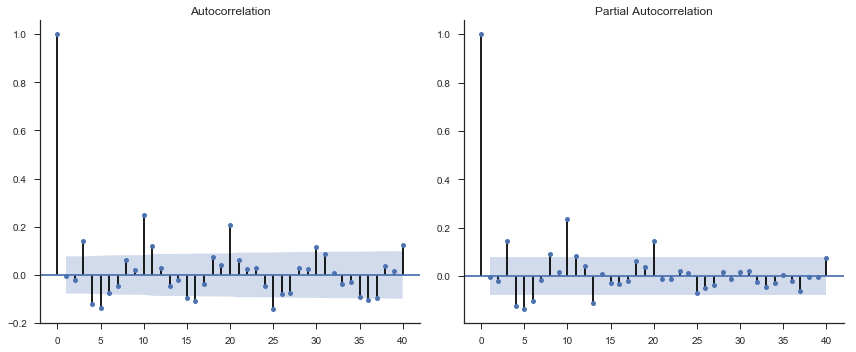

In [70]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid3, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid3, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

ARMA(1,1) model with $\textbf{first difference}$ appears to do best.

Residual analysis to see if we missed anything.

https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c

## Final conclusion regarding ARMA models

Since data is not already stationary, we decide to take the difference and in order to set the parameters p and q for the ARMA(p,q) model, we choose the ARMA(1,1) model since it has the lowest AIC score.

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

# Seasonal ARMA

### OKAY I MADE A TYPO HERE WHERE I SET Y = DIFF (differenced of Y) so whenever you see y, it is actually diff from here onwards. So if I said a model is ARIMA(1,0,1), the data is differenced already so it should be ARIMA(1,0,1). Likewise for seasonal arima (or sarima), will now be: AR(2,1,0)(1,0,0) instead of AR(2,0,0)(1,0,0). Sorry!

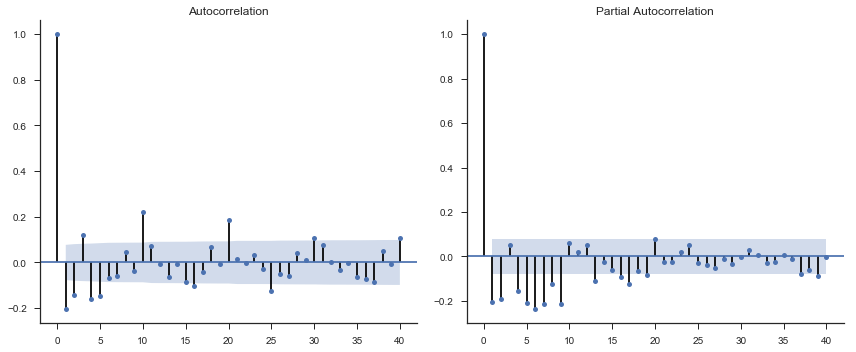

In [127]:
y=diff

fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

Analysing autocorrelation for the differenced data set. Quite good as ACF drops dramatically. Appears that last 2 periods are useful from autocorrelation plot (u can extend this to 5, but just cbs to do AR(5)). Furthermore from PACF, we use MA(1). 

In terms of seasonality, seems like every 11 months (roughly) there is a seasonal pattern. Therefore we take m=11 (slide 53)

In [86]:
diff_data = diff.values.astype(float)
mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(1,0,1), seasonal_order=(1,0,0,11))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  646
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 11)   Log Likelihood               -5260.795
Date:                            Wed, 01 Nov 2017   AIC                          10529.590
Time:                                    15:34:37   BIC                          10547.474
Sample:                                01-03-2013   HQIC                         10536.529
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5727      0.024     24.132      0.000       0.526       0.619
ma.L1         -0.9993      0.025   

This is a seasonal ARIMA model with (1, 0, 1)(1, 0, 0$)_{11}$ Improvement in model! This does better than (0, 1, 1$)_{11}$ seasonal ARIMA below.

In [88]:
diff_data = diff.values.astype(float)
mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(1,0,1), seasonal_order=(0,0,1,11))
results = mod.fit()
print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  646
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 11)   Log Likelihood               -5261.102
Date:                            Wed, 01 Nov 2017   AIC                          10530.203
Time:                                    15:35:06   BIC                          10548.087
Sample:                                01-03-2013   HQIC                         10537.142
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5756      0.024     24.233      0.000       0.529       0.622
ma.L1         -1.0000      0.042   

We can select best Seasonal ARIMA model via AIC

In [105]:
diff_data = diff.values.astype(float)

min_aic = 100000
#Normal ARMA model
p_opt = 0
q_opt = 0
#Seasonal ARMA
P_opt = 0
Q_opt = 0
for i in range(0,4):
    for j in range(0,3):    
        for k in range(0,2):
            for l in range(0,2):
                try:
                    if i == 0 and j ==0:
                        #Can't have a ARMA(0, 0) model.
                        i = 1
                    mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(i, 0, j), seasonal_order=(k, 0, l, 11))
                    results = mod.fit()
                    if results.aic<min_aic:
                        min_aic = results.aic
                        p_opt = i
                        q_opt = j
                        P_opt = k
                        Q_opt = l
                except:
                    continue
print('Optimal model is ({}, 0, {})({}, 0, {}) with an AIC of {}'.format(p_opt+1, q_opt, P_opt, Q_opt, min_aic))
mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(p_opt+1, 0, q_opt), seasonal_order=(P_opt, 0, Q_opt,11))
results = mod.fit()
print(results.summary())

Optimal model is (2, 0, 1)(1, 0, 0) with an AIC of 10529.590494150661
                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  646
Model:             SARIMAX(2, 0, 1)x(1, 0, 0, 11)   Log Likelihood               -5303.333
Date:                            Wed, 01 Nov 2017   AIC                          10616.667
Time:                                    15:57:28   BIC                          10639.021
Sample:                                01-03-2013   HQIC                         10625.340
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6145      0.173     -3.561 

With our final model for seasonal ARIMA, lets do some validation!

In [107]:
# Real time forecasting for one year
validation=diff['2015-06-01':].index # 
start = diff.index.get_loc('2015-06-01') # 
y = diff.astype(float)

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 0, 1), seasonal_order=(1, 0, 0, 11)).fit()
    results.iloc[j,0]=model.forecast()[0]
    
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal ARIMA,746.121,122.06


Seasonal ARIMA looks really good compared to other models. (Check which one is the best).

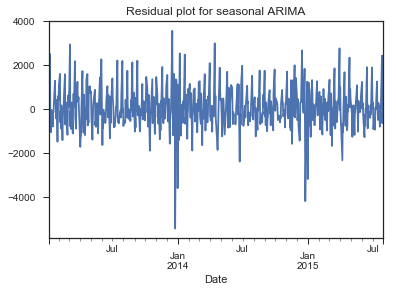

In [110]:
mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(p_opt+1, 0, q_opt), seasonal_order=(P_opt, 0, Q_opt,11))
mod = mod.fit()
resid=pd.Series(mod.resid, index=y.index)
resid.plot()
plt.title('Residual plot for seasonal ARIMA')
plt.show()

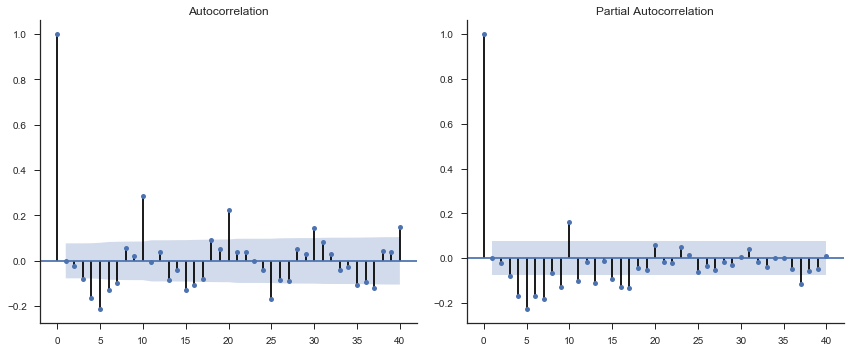

In [112]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

Residuals look alright.

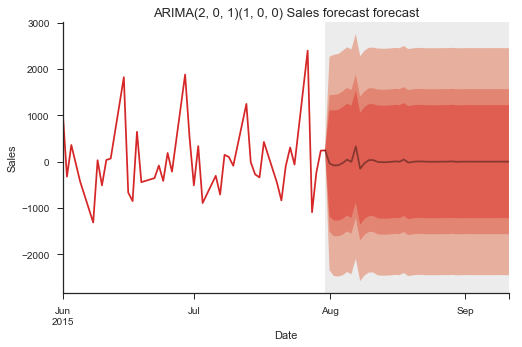

In [129]:
h=42
mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(p_opt+1, 0, q_opt), seasonal_order=(P_opt, 0, Q_opt,11))
mod = mod.fit()
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred = mod.forecast(steps=h)
y_pred =  pd.Series(y_pred, index=test)

intv1 = mod.get_forecast(h).conf_int(alpha=0.2)
intv2 = mod.get_forecast(h).conf_int(alpha=0.1)
intv3 = mod.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['2015-06-01':], y_pred, intv1, intv2, intv3)
ax.set_xlabel('Date')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(2, 0, 1)(1, 0, 0) Sales forecast forecast', fontsize=13)
sns.despine()
plt.show()

### Bonus Task: Forecasting for every store

In [2]:
"""Get stores, remove weekends, and holidays."""
def process_data(store_num):
    finaldata=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
    finaldata = finaldata[finaldata['Store']==store_num]
    noweekendfinaldata = finaldata[finaldata['DayOfWeek'] != 6]
    noweekendfinaldata2 = noweekendfinaldata[noweekendfinaldata['DayOfWeek'] != 7]
    dummies = pd.get_dummies(noweekendfinaldata2[['StateHoliday']],  drop_first=True)
    noweekendfinaldata2=noweekendfinaldata2.join(dummies)
    noweekendfinaldata2.rename(columns={'StateHoliday_0':'NoHoliday',
                                        'StateHoliday_a': 'PublicHoliday', 
                                        'StateHoliday_b': 'EasterHoliday', 
                                        'StateHoliday_c':'ChristmasHoliday'}, inplace=True)

    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['PublicHoliday'] != 1]
    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['EasterHoliday'] != 1]
    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['ChristmasHoliday'] != 1]
    del noweekendfinaldata2['NoHoliday']
    del noweekendfinaldata2['StateHoliday']
    del noweekendfinaldata2['Store']
    del noweekendfinaldata2['PublicHoliday']
    del noweekendfinaldata2['EasterHoliday']
    del noweekendfinaldata2['ChristmasHoliday']
    noweekendfinaldata2.index=noweekendfinaldata2.index.to_period(freq='D')
    y = noweekendfinaldata2['Sales']
    y = y.iloc[::-1]
    return y

In [128]:
#We create a list to contain all forecasts for each store (which they themselves are also lists.)
all_forecasts = []
for i in range(1, 1116):
    '''Gets each store individual and fit SES model to each one. 
       We then save results into a csv file containing predictions.'''
    y = process_data(i)
    validation=y['2015-06-01':].index # 
    start = y.index.get_loc('2015-06-01') # 
    y = y.astype(float)

    forecasts = []

    for i in range(start, len(y)):
        j=i-start
        # simple exponential smoothing
        model = forecast.ses(y.iloc[:i]) 
        model.fit()
        forecasts.append(model.forecast(1)[0])
    all_forecasts.append(forecasts)
#We now have each forecast for every store in all_forecasts

NameError: name 'process_data' is not defined

In [5]:
#We create a list to contain all forecasts for each store (which they themselves are also lists.)
all_forecasts2 = []
for i in range(1, 1116):
    '''Gets each store individual and fit SARIMA model to each one. 
       We then save results into a csv file containing predictions.'''
    y = process_data(i)
    validation=y['2015-06-01':].index # 
    start = y.index.get_loc('2015-06-01') # 
    y = y.astype(float)

    forecasts = []

    for i in range(start, len(y)):
        j=i-start
        # simple exponential smoothing
        model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 1, 1), seasonal_order=(1, 0, 0, 11)).fit()
        forecasts.append(model.forecast()[0])
    all_forecasts2.append(forecasts)
#We now have each forecast for every store in all_forecasts

In [5]:
def plot_desired_store(i):
    y = process_data(i)
    h=42
    model=forecast.ses(y)
    model.fit()
    fitted2=pd.Series(model.smooth(), index=y.index)
    model.summary()
    test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

    pred=pd.Series(model.forecast(h), index=test)

    intv1=pd.DataFrame(model.intervalforecast(h, level=.8), index=test)
    intv2=pd.DataFrame(model.intervalforecast(h, level=.9), index=test)
    intv3=pd.DataFrame(model.intervalforecast(h, level=.99), index=test)

    fig, ax = forecast.fanchart(y['2015-06-01':], pred, intv1, intv2, intv3)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.set_xticks([], minor=True)
    plt.title('Sales forecast (simple exponential smoothing) for store {}'.format(i))

    sns.despine()
    plt.show()

Please input which store you would like forecasts for: 15
Proccessing for store 15...
 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.681 (0.199) 

 In-sample fit:
 MSE               2596968.923
 Log-likelihood   -5722.513
 AIC               11451.026
 BIC               11464.457


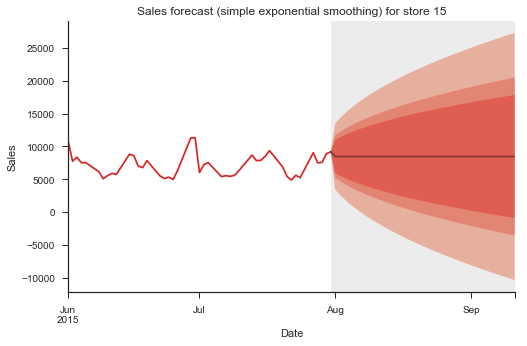

In [7]:
store_desire = input("Please input which store you would like forecasts for: ")
print("Proccessing for store {}...".format(store_desire))
plot_desired_store(int(store_desire))